In [16]:
! pip install nibabel
! pip install nilearn
! pip install -q nilearn
import nibabel as nib
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nilearn.image import resample_to_img
from nilearn.plotting import plot_roi, show

In [17]:
run='1'
behav_data_path = '/Users/graceliu/Desktop/ColumbiaThesis/data/trial_by_trial_WSW_with_ratings.csv'
behav_df = pd.read_csv(behav_data_path)

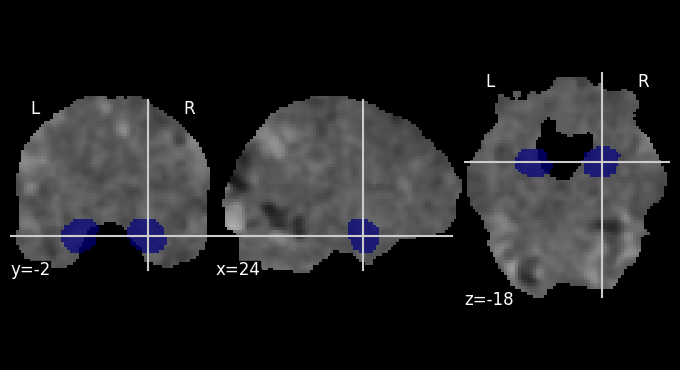

In [18]:
### resample amygdala mask -- use previous hipp code 

#subject 001 zmap (reference image)
run1 = "/Users/graceliu/Desktop/ColumbiaThesis/zmaps/sub-001_encoding_correct_within_bt2_between_error_zmap.nii.gz"
img = nib.load(run1)

#amygdala mask (source image)
amy_file_path = "/Users/graceliu/Desktop/ColumbiaThesis/brain_masks/amygdala_association-test_z_FDR_0.01.nii.gz"
amy_img = nib.load(amy_file_path)

#resample amygdala mask to match Z-map
resampled_amy_mask = resample_to_img(amy_img, img, interpolation='continuous')

#convert resampled mask to numpy array
resampled_mask_data = resampled_amy_mask.get_fdata()

#apply threshold to only focus on amy ROI
binary_mask = (resampled_mask_data > 12).astype(np.uint8)

#save resampled mask as a new NIfTI file
mask_img = nib.Nifti1Image(binary_mask, resampled_amy_mask.affine, resampled_amy_mask.header)

amy_save_path = "/Users/graceliu/Desktop/ColumbiaThesis/brain_masks/amygdala_resampled.nii.gz"
nib.save(mask_img, amy_save_path)

plot_roi(mask_img, bg_img = img)
show()

# Individual face neural patterns during cateogry localizer for a two group split: untrustworthy vs. trustworthy

In [19]:
all_TD_ratings_path = '/Users/graceliu/Desktop/ColumbiaThesis/data/T_D_ratings_WSW.csv'
all_TD_ratings = pd.read_csv(all_TD_ratings_path)
all_TD_ratings.head()

,Model,Trustworthy Rating,Dominant Rating
0,BM-001,3.063830,3.230769
1,BM-002,3.617021,3.703704
2,BM-003,2.813187,4.200000
3,BM-004,3.178295,2.695312
4,BM-005,3.315217,2.846154


## All faces

In [20]:
map_root = "/Users/graceliu/Desktop/ColumbiaThesis/individual_ID_maps"

amyg_mask_img = nib.load("/Users/graceliu/Desktop/ColumbiaThesis/brain_masks/amygdala_resampled.nii.gz")
amyg_data = amyg_mask_img.get_fdata().astype(bool)

trustworthy_vals, untrustworthy_vals = [], []
for sub in range(1, 33):
    sub_id = f"sub-{sub:03d}"
    if sub_id == "sub-011":
        continue

    #check if subject folder exists before continuing    
    sub_folder = os.path.join(map_root, sub_id)
    if not os.path.isdir(sub_folder):
        print(sub_folder, 'FOLDER DOES NOT EXIST')

    face_ids_seen = []

    # First pass: collect all face IDs this subject has seen (from file names)
    for f in os.listdir(sub_folder):
        if f.endswith(".nii.gz"):
            face_id = f.split("_")[1]  # assumes format like sub-001_BM-001_run-1.nii.gz
            face_ids_seen.append(face_id)

    # check if there are duplicates
    assert len(face_ids_seen) == len(set(face_ids_seen)), f"ERROR: there are duplicates!"

    # Get trust ratings for only the faces this subject saw
    sub_ratings = all_TD_ratings[all_TD_ratings["Model"].isin(face_ids_seen)]  

    sub_median = sub_ratings["Trustworthy Rating"].median()

    # Second pass: process each face file
    for f in os.listdir(sub_folder):
        if f.endswith(".nii.gz"):
            face_id = f.split("_")[1]

            # Get the trust rating for this face
            row = all_TD_ratings[all_TD_ratings["Model"] == face_id]
            if row.empty:
                print("Error")
                print(row)
            trust_rating = row["Trustworthy Rating"].values[0]

            # Load neural data
            map_path = os.path.join(sub_folder, f)
            img = nib.load(map_path)
            data = img.get_fdata()
            mean_amyg = np.nanmean(data[amyg_data])

            # Classify based on subject-specific median
            if trust_rating > sub_median:
                trustworthy_vals.append(mean_amyg)
            else:
                untrustworthy_vals.append(mean_amyg)

# Final average results
print(f"Trustworthy mean: {np.mean(trustworthy_vals):.4f} (n={len(trustworthy_vals)})")
print(f"Untrustworthy mean: {np.mean(untrustworthy_vals):.4f} (n={len(untrustworthy_vals)})")

Trustworthy mean: 0.0325 (n=1860)
Untrustworthy mean: 0.0311 (n=1860)


In [21]:
from scipy.stats import ttest_ind

t_stat, p_val = ttest_ind(trustworthy_vals, untrustworthy_vals, equal_var=False)
print(f"t = {t_stat:.4f}")
print(f"p = {p_val:.4f}")

t = 0.4405
p = 0.6596


### ** for neural diff download **

In [39]:
## download neural activation differences into csv

subject_ids = []
trustworthy_vals_subj = []
untrustworthy_vals_subj = []

# Loop through subjects
for sub in range(1, 33):
    sub_id = f"sub-{sub:03d}"
    if sub_id == "sub-011":
        continue  # skip subject 11

    sub_folder = os.path.join(map_root, sub_id)
    if not os.path.isdir(sub_folder):
        print(sub_folder, 'FOLDER DOES NOT EXIST')
        continue

    face_ids_seen = []
    for f in os.listdir(sub_folder):
        if f.endswith(".nii.gz"):
            face_id = f.split("_")[1]
            face_ids_seen.append(face_id)

    # Check for duplicates
    assert len(face_ids_seen) == len(set(face_ids_seen)), f"ERROR: duplicates for {sub_id}"

    # Get trust ratings for faces this subject saw
    sub_ratings = all_TD_ratings[all_TD_ratings["Model"].isin(face_ids_seen)]
    sub_median = sub_ratings["Trustworthy Rating"].median()

    # Prepare per-condition storage
    sub_trust_vals = []
    sub_untrust_vals = []

    for f in os.listdir(sub_folder):
        if f.endswith(".nii.gz"):
            face_id = f.split("_")[1]
            row = all_TD_ratings[all_TD_ratings["Model"] == face_id]
            if row.empty:
                print("Error: face rating not found for", face_id)
                continue
            trust_rating = row["Trustworthy Rating"].values[0]

            # Load beta map
            map_path = os.path.join(sub_folder, f)
            img = nib.load(map_path)
            data = img.get_fdata()
            mean_amyg = np.nanmean(data[amyg_data])

            # Subject-specific split
            if trust_rating > sub_median:
                sub_trust_vals.append(mean_amyg)
            else:
                sub_untrust_vals.append(mean_amyg)

    # Store subject-level means
    subject_ids.append(sub_id)
    trustworthy_vals_subj.append(np.mean(sub_trust_vals))
    untrustworthy_vals_subj.append(np.mean(sub_untrust_vals))

# Compute neural difference
neural_diff = np.array(trustworthy_vals_subj) - np.array(untrustworthy_vals_subj)

# Save to DataFrame
neural_diff_df = pd.DataFrame({
    "subj_id": subject_ids,
    "mean_trustworthy": trustworthy_vals_subj,
    "mean_untrustworthy": untrustworthy_vals_subj,
    "neural_diff": neural_diff
})

# Export to CSV
neural_diff_df.to_csv("neural_trust_diff_by_subject.csv", index=False)
print("Saved: neural_trust_diff_by_subject.csv")

Saved: neural_trust_diff_by_subject.csv


No significant difference in amygdala activity between the groups.

## BM only

In [22]:
trustworthy_vals, untrustworthy_vals = [], []
for sub in range(1, 33):
    sub_id = f"sub-{sub:03d}"
    if sub_id == "sub-011":
        continue

    #check if subject folder exists before continuing    
    sub_folder = os.path.join(map_root, sub_id)
    if not os.path.isdir(sub_folder):
        print(sub_folder, 'FOLDER DOES NOT EXIST')

    face_ids_seen = []

    # First pass: collect all face IDs this subject has seen (from file names)
    for f in os.listdir(sub_folder):
        if f.endswith(".nii.gz") and "BM-" in f:
            face_id = f.split("_")[1]  # assumes format like sub-001_BM-001_run-1.nii.gz
            face_ids_seen.append(face_id)

    # check if there are duplicates
    assert len(face_ids_seen) == len(set(face_ids_seen)), f"ERROR: there are duplicates!"

    # Get trust ratings for only the faces this subject saw
    sub_ratings = all_TD_ratings[all_TD_ratings["Model"].isin(face_ids_seen)]  

    sub_median = sub_ratings["Trustworthy Rating"].median()

    # Second pass: process each face file
    for f in os.listdir(sub_folder):
        if f.endswith(".nii.gz") and "BM-" in f:
            face_id = f.split("_")[1]

            # Get the trust rating for this face
            row = all_TD_ratings[all_TD_ratings["Model"] == face_id]
            if row.empty:
                print("Error")
                print(row)
            trust_rating = row["Trustworthy Rating"].values[0]

            # Load neural data
            map_path = os.path.join(sub_folder, f)
            img = nib.load(map_path)
            data = img.get_fdata()
            mean_amyg = np.nanmean(data[amyg_data])

            # Classify based on subject-specific median
            if trust_rating > sub_median:
                trustworthy_vals.append(mean_amyg)
            else:
                untrustworthy_vals.append(mean_amyg)

# Final average results
print(f"Trustworthy mean: {np.mean(trustworthy_vals):.4f} (n={len(trustworthy_vals)})")
print(f"Untrustworthy mean: {np.mean(untrustworthy_vals):.4f} (n={len(untrustworthy_vals)})")

Trustworthy mean: 0.0347 (n=930)
Untrustworthy mean: 0.0306 (n=930)


In [23]:
t_stat, p_val = ttest_ind(trustworthy_vals, untrustworthy_vals, equal_var=False)
print(f"t = {t_stat:.4f}")
print(f"p = {p_val:.4f}")

t = 0.9186
p = 0.3584


## WM only

In [24]:
trustworthy_vals, untrustworthy_vals = [], []
for sub in range(1, 33):
    sub_id = f"sub-{sub:03d}"
    if sub_id == "sub-011":
        continue

    #check if subject folder exists before continuing    
    sub_folder = os.path.join(map_root, sub_id)
    if not os.path.isdir(sub_folder):
        print(sub_folder, 'FOLDER DOES NOT EXIST')

    face_ids_seen = []

    # First pass: collect all face IDs this subject has seen (from file names)
    for f in os.listdir(sub_folder):
        if f.endswith(".nii.gz") and "WM-" in f:
            face_id = f.split("_")[1]  # assumes format like sub-001_BM-001_run-1.nii.gz
            face_ids_seen.append(face_id)

    # check if there are duplicates
    assert len(face_ids_seen) == len(set(face_ids_seen)), f"ERROR: there are duplicates!"

    # Get trust ratings for only the faces this subject saw
    sub_ratings = all_TD_ratings[all_TD_ratings["Model"].isin(face_ids_seen)]  

    sub_median = sub_ratings["Trustworthy Rating"].median()

    # Second pass: process each face file
    for f in os.listdir(sub_folder):
        if f.endswith(".nii.gz") and "WM-" in f:
            face_id = f.split("_")[1]

            # Get the trust rating for this face
            row = all_TD_ratings[all_TD_ratings["Model"] == face_id]
            if row.empty:
                print("Error")
                print(row)
            trust_rating = row["Trustworthy Rating"].values[0]

            # Load neural data
            map_path = os.path.join(sub_folder, f)
            img = nib.load(map_path)
            data = img.get_fdata()
            mean_amyg = np.nanmean(data[amyg_data])

            # Classify based on subject-specific median
            if trust_rating > sub_median:
                trustworthy_vals.append(mean_amyg)
            else:
                untrustworthy_vals.append(mean_amyg)

# Final average results
print(f"Trustworthy mean: {np.mean(trustworthy_vals):.4f} (n={len(trustworthy_vals)})")
print(f"Untrustworthy mean: {np.mean(untrustworthy_vals):.4f} (n={len(untrustworthy_vals)})")

Trustworthy mean: 0.0284 (n=930)
Untrustworthy mean: 0.0336 (n=930)


In [25]:
t_stat, p_val = ttest_ind(trustworthy_vals, untrustworthy_vals, equal_var=False)
print(f"t = {t_stat:.4f}")
print(f"p = {p_val:.4f}")

t = -1.2020
p = 0.2295


# Dom vs. nondom
## All faces

In [40]:
dominant_vals, nondominant_vals = [], []
for sub in range(1, 33):
    sub_id = f"sub-{sub:03d}"
    if sub_id == "sub-011":
        continue

    #check if subject folder exists before continuing    
    sub_folder = os.path.join(map_root, sub_id)
    if not os.path.isdir(sub_folder):
        print(sub_folder, 'FOLDER DOES NOT EXIST')

    face_ids_seen = []

    # First pass: collect all face IDs this subject has seen (from file names)
    for f in os.listdir(sub_folder):
        if f.endswith(".nii.gz"):
            face_id = f.split("_")[1]  # assumes format like sub-001_BM-001_run-1.nii.gz
            face_ids_seen.append(face_id)

    # check if there are duplicates
    assert len(face_ids_seen) == len(set(face_ids_seen)), f"ERROR: there are duplicates!"

    # Get trust ratings for only the faces this subject saw
    sub_ratings = all_TD_ratings[all_TD_ratings["Model"].isin(face_ids_seen)]  

    sub_median = sub_ratings["Dominant Rating"].median()

    # Second pass: process each face file
    for f in os.listdir(sub_folder):
        if f.endswith(".nii.gz"):
            face_id = f.split("_")[1]

            # Get the trust rating for this face
            row = all_TD_ratings[all_TD_ratings["Model"] == face_id]
            if row.empty:
                print("Error")
                print(row)
            dom_rating = row["Dominant Rating"].values[0]

            # Load neural data
            map_path = os.path.join(sub_folder, f)
            img = nib.load(map_path)
            data = img.get_fdata()
            mean_amyg = np.nanmean(data[amyg_data])

            # Classify based on subject-specific median
            if dom_rating > sub_median:
                dominant_vals.append(mean_amyg)
            else:
                nondominant_vals.append(mean_amyg)

# Final average results
print(f"Dominant mean: {np.mean(dominant_vals):.4f} (n={len(dominant_vals)})")
print(f"Non Dominant mean: {np.mean(nondominant_vals):.4f} (n={len(nondominant_vals)})")

Dominant mean: 0.0338 (n=1860)
Non Dominant mean: 0.0298 (n=1860)


In [41]:
t_stat, p_val = ttest_ind(dominant_vals, nondominant_vals, equal_var=False)
print(f"t = {t_stat:.4f}")
print(f"p = {p_val:.4f}")

t = 1.2702
p = 0.2041


## BM only

In [42]:
dominant_vals, nondominant_vals = [], []
for sub in range(1, 33):
    sub_id = f"sub-{sub:03d}"
    if sub_id == "sub-011":
        continue

    #check if subject folder exists before continuing    
    sub_folder = os.path.join(map_root, sub_id)
    if not os.path.isdir(sub_folder):
        print(sub_folder, 'FOLDER DOES NOT EXIST')

    face_ids_seen = []

    # First pass: collect all face IDs this subject has seen (from file names)
    for f in os.listdir(sub_folder):
        if f.endswith(".nii.gz") and 'BM-' in f:
            face_id = f.split("_")[1]  # assumes format like sub-001_BM-001_run-1.nii.gz
            face_ids_seen.append(face_id)

    # check if there are duplicates
    assert len(face_ids_seen) == len(set(face_ids_seen)), f"ERROR: there are duplicates!"

    # Get trust ratings for only the faces this subject saw
    sub_ratings = all_TD_ratings[all_TD_ratings["Model"].isin(face_ids_seen)]  

    sub_median = sub_ratings["Dominant Rating"].median()

    # Second pass: process each face file
    for f in os.listdir(sub_folder):
        if f.endswith(".nii.gz") and 'BM-' in f:
            face_id = f.split("_")[1]

            # Get the trust rating for this face
            row = all_TD_ratings[all_TD_ratings["Model"] == face_id]
            if row.empty:
                print("Error")
                print(row)
            dom_rating = row["Dominant Rating"].values[0]

            # Load neural data
            map_path = os.path.join(sub_folder, f)
            img = nib.load(map_path)
            data = img.get_fdata()
            mean_amyg = np.nanmean(data[amyg_data])

            # Classify based on subject-specific median
            if dom_rating > sub_median:
                dominant_vals.append(mean_amyg)
            else:
                nondominant_vals.append(mean_amyg)

# Final average results
print(f"Dominant mean: {np.mean(dominant_vals):.4f} (n={len(dominant_vals)})")
print(f"Non Dominant mean: {np.mean(nondominant_vals):.4f} (n={len(nondominant_vals)})")

Dominant mean: 0.0311 (n=930)
Non Dominant mean: 0.0342 (n=930)


In [43]:
t_stat, p_val = ttest_ind(dominant_vals, nondominant_vals, equal_var=False)
print(f"t = {t_stat:.4f}")
print(f"p = {p_val:.4f}")

t = -0.6926
p = 0.4886


## WM only

In [44]:
dominant_vals, nondominant_vals = [], []
for sub in range(1, 33):
    sub_id = f"sub-{sub:03d}"
    if sub_id == "sub-011":
        continue

    #check if subject folder exists before continuing    
    sub_folder = os.path.join(map_root, sub_id)
    if not os.path.isdir(sub_folder):
        print(sub_folder, 'FOLDER DOES NOT EXIST')

    face_ids_seen = []

    # First pass: collect all face IDs this subject has seen (from file names)
    for f in os.listdir(sub_folder):
        if f.endswith(".nii.gz") and 'WM-' in f:
            face_id = f.split("_")[1]  # assumes format like sub-001_BM-001_run-1.nii.gz
            face_ids_seen.append(face_id)

    # check if there are duplicates
    assert len(face_ids_seen) == len(set(face_ids_seen)), f"ERROR: there are duplicates!"

    # Get trust ratings for only the faces this subject saw
    sub_ratings = all_TD_ratings[all_TD_ratings["Model"].isin(face_ids_seen)]  

    sub_median = sub_ratings["Dominant Rating"].median()

    # Second pass: process each face file
    for f in os.listdir(sub_folder):
        if f.endswith(".nii.gz") and 'WM-' in f:
            face_id = f.split("_")[1]

            # Get the trust rating for this face
            row = all_TD_ratings[all_TD_ratings["Model"] == face_id]
            if row.empty:
                print("Error")
                print(row)
            dom_rating = row["Dominant Rating"].values[0]

            # Load neural data
            map_path = os.path.join(sub_folder, f)
            img = nib.load(map_path)
            data = img.get_fdata()
            mean_amyg = np.nanmean(data[amyg_data])

            # Classify based on subject-specific median
            if dom_rating > sub_median:
                dominant_vals.append(mean_amyg)
            else:
                nondominant_vals.append(mean_amyg)

# Final average results
print(f"Dominant mean: {np.mean(dominant_vals):.4f} (n={len(dominant_vals)})")
print(f"Non Dominant mean: {np.mean(nondominant_vals):.4f} (n={len(nondominant_vals)})")

Dominant mean: 0.0344 (n=930)
Non Dominant mean: 0.0276 (n=930)


In [45]:
t_stat, p_val = ttest_ind(dominant_vals, nondominant_vals, equal_var=False)
print(f"t = {t_stat:.4f}")
print(f"p = {p_val:.4f}")

t = 1.5897
p = 0.1121


In [26]:
'''Individual face neural patterns during cateogry localizer for a three group split: untrustworthy vs. neutral vs. trustworthy'''

'Individual face neural patterns during cateogry localizer for a three group split: untrustworthy vs. neutral vs. trustworthy'